## Advanced NLP: Assignment 3
In this experiment we compare the performance of two BERT-based models in the task of Semantic Role Labeling (SRL). A classic SRL task consists of the four general steps:

1. Predicate identification
2. Predicate classification
3. Argument identification
4. Argument classification

In this task we focus on the last two steps: Argument Identification and Argument classification. The first model (baseline) does not exactly know where in the sentence a predicate is. The second model (the advanced) has a special token that indicates the position of the predicate in the sentence.

In [ ]:
#!pip install -q transformers
#!pip install -q accelerate -U
# restart runtime after installing the above packages
import transformers
import pandas as pd

from data_utils import *
from feature_utils import *

In [ ]:
# Global parameters: (Unfortunately we had to use global params since we trained on colab; We appologize in advance)
BASELINE = False # True for baseline model, false for advanced
MODEL_NAME = "distilbert-base-uncased"
MULTILABEL = True # true for Argument Classification; false for Argument Identification

if MULTILABEL:
    task = 'argument-classification' # multilabel
else:
    task = 'argument-identification' # binary

if BASELINE:
    model_type = 'baseline'
else:
    model_type = 'advanced'

# Preprocessing data
The data used in this experiment is the "[The EN Universal Propban dataset](https://github.com/UniversalPropositions/UP-1.0/tree/master/UP_English-EWT)". This dataset is in the CoNLL format. The first step is to convert the data to a format that can be used by the BERT models. The following code accomplishes this conversion (The actual functions are in the data_utils.py).


In [ ]:
train_path = '../Data/en_ewt-up-train.conllu'
dev_path = '../Data/en_ewt-up-dev.conllu'
test_path = '../Data/en_ewt-up-test.conllu'

In [ ]:
train_data = conll_transform(read_conll(train_path))
dev_data = conll_transform(read_conll(dev_path))
test_data = conll_transform(read_conll(test_path))

In [ ]:
train_data = extract_predicate_argument_feats(train_data)
dev_data = extract_predicate_argument_feats(dev_data)
test_data = extract_predicate_argument_feats(test_data)

In [ ]:
# get rid of unnecessary columns
train_data.drop(['lemma', 'POS','morph_type','distance_head','dep_label','dep_rel'], axis=1, inplace=True)
dev_data.drop(['lemma', 'POS','morph_type','distance_head','dep_label','dep_rel'], axis=1, inplace=True)
test_data.drop(['lemma', 'POS','morph_type','distance_head','dep_label','dep_rel'], axis=1, inplace=True)

In [ ]:
train_data.head()

,sent_id,token_id,token,Universal_POS,space,predicate,argument_type,is_token_predicate,is_token_argument,argument_label
0,weblog-juancole.com_juancole_20051126063000_EN...,1,Al,NNP,SpaceAfter=No,_,_,0,0,O
1,weblog-juancole.com_juancole_20051126063000_EN...,2,-,HYPH,SpaceAfter=No,_,_,0,0,O
2,weblog-juancole.com_juancole_20051126063000_EN...,3,Zaman,NNP,_,_,_,0,0,O
3,weblog-juancole.com_juancole_20051126063000_EN...,4,:,:,_,_,_,0,0,O
4,weblog-juancole.com_juancole_20051126063000_EN...,5,American,JJ,_,_,_,0,0,O


The various argument classification labels are shown below:

In [ ]:
if task == 'argument-identification':
    label_list = set(train_data['is_token_argument'].tolist())
    print(label_list)
elif task == 'argument-classification':
    label_list = set(train_data['argument_label'].tolist())
    # for mapping str labels to int:
    label_mapping = {}
    for e, label in enumerate(label_list):
        label_mapping.update({label: int(e)})
    print("argument classification labels:",label_list)

argument classification labels: {'ARGM-PRR', 'ARG3', 'ARG4', 'ARGM-DIR', 'ARGM-DIS', 'ARG2', 'ARGM-LOC', 'ARGM-CXN', 'ARG1-DSP', 'O', 'ARGM-PRD', 'ARGM-MOD', 'ARGM-LVB', 'ARG5', 'ARGM-REC', 'ARGM-ADV', 'ARG0', 'ARGA', 'ARG1', 'ARGM-EXT', 'ARGM-TMP', 'ARGM-COM', 'ARGM-GOL', 'ARGM-CAU', 'ARGM-PRP', 'ARGM-MNR', 'ARGM-ADJ', 'ARGM-NEG'}


Next we extract the tokens, predicates and argument labels of a sentence from the Train, Development and Test datasets and convert them to lists of tokens, predicates and argument labels. The approaches taken for the two models difere slightly. They are discussed below along with their limitations.<br><br>

---

**Baseline Approach:**

For the baseline model, the token lists (which represent the words in a sentence) are appended by the: [SEP][predicate] before the end of the sentence where [SEP] is the special token that separates the sentence from the predicate and [predicate] is the predicate token(see: Lin et. al. [2019](https://arxiv.org/pdf/1904.05255.pdf),). For example, see the sentence below:

<center> [CLS] Barack Obama went to Paris [SEP] went [SEP] </center>

Here [CLS] is the special token that indicates the start of the sentence and [SEP] is the special token that separates the sentence from the predicate. The predicate is "went" which is appended before the end of the sentence. <br><br>

**Limitations**

1. The baseline model is not directly informed about the location of predicate in a sentence. The predicate is just merely appended to the end of the sentence.

2. Ambiguity with Multiple Occurrences of the Same Predicate: In sentences where the same predicate appears more than once, this simple representation can lead to ambiguity. The model might struggle to distinguish between different instances of the same predicate, affecting its ability to accurately label argument tokens

3. Limited Contextual Understanding: The baseline model's simple input format may not provide enough context for the model to fully understand the relationship between the predicate and its arguments. This could result in less accurate argument labeling, especially in complex sentences with multiple predicates or nuanced syntactic structures.

In short using this approach results in loss of contexual information and introduces semantic ambiguity.

---

**Advanced Approach:**

For the advanced model, the token lists are appened by the special token [PREDICATE] before each predicate token in a sentence. This is smilar to the 'Augment' strategy used in [NegBERT](http://www.lrec-conf.org/proceedings/lrec2020/pdf/2020.lrec-1.704.pdf) by Khandelwal et al. For example, see the sentence below:

<center> [CLS] Barack Obama [PREDICATE] went to Paris [SEP]</center>


Limitations and possible improvements:

1. Although this approach directly infroms the model where the predicate is in the sentence, it is still may not be sufficient for the disambiguation of multiple occurences of the same predicate in the sentence. A better approach maybe to mark the end of the predicate by a closing special token '[/PREDICATE]'.  This makes it unambiguous which "went" is the target predicate, even if the word appears multiple times in the example above.

2. This approach still uses one predicate special token to learn predicate-argument structures in sentences. This may not be sufficianet. It may be beneficial to include addional special predicate tokens eg. [PREDICATE1], [PREDICATE2] etc. for sentences with multiple predicates. It allows the model to unambiguously identify which predicate each argument belongs to. In sentences with multiple predicates, just marking a single predicate may lead to confusion about which arguments correspond to which predicate. Having distinct predicate tokens removes this ambiguity. The model can also learn predicate-specific representations for the arguments. By associating each argument with a specific predicate token, the model can capture the unique semantic roles played by the arguments with respect to each predicate.

---

**Label Preprocessing:**



To process the arugment labels we numerically encode them. The special tokens ([CLS], [SEP], [PREDICATE]) and the predicate added to the end of the sentences in the baseline model are assigned a label of -100 so that they are not considered in the loss function.

In [ ]:
def extract_sentences(df: pd.DataFrame, baseline, multilabel):
    """
    Extracts sentences, argument ids and labels from conll format
    and puts it into lists, so that each element of list is list of sentence tokens/labels/ids.
    Also applying either baseline or advanced model transformations for a sentence.

    params:
    df: DataFrame of transformed conll with predicate argument features.
    Baseline: True for baseline model else advanced model.

    Returns:
    sentences: list of lists where each element is a token of given sentence.
    arguments: list of lists of argument ids (binary).
    arg_label: list of lists of argument labels (multilabel).
    sentence_ids: list of sentence ids

    """
    model_type = 'baseline' if baseline else 'advanced'

    sentences = []
    arguments = [] # for argument ids (binary)
    arg_label = [] # for argument labels (multilabel)
    sentence_ids = []

    current_sent = []
    current_sent_arguments = []
    current_sent_arg_label = []


    for _, row in df.iterrows():
        if row['token_id'] == '1' and current_sent:
            if model_type == 'baseline':
                # add everything for baseline predicate mark at the end of sentence
                current_sent.append('[SEP]')
                current_sent.append(predicate_token)
                current_sent_arguments.append(-100)
                current_sent_arguments.append(-100)
                current_sent_arg_label.append(-100)
                current_sent_arg_label.append(-100)


            sentences.append(current_sent)
            arguments.append(current_sent_arguments)
            arg_label.append(current_sent_arg_label)
            sentence_ids.append(current_id)

            current_sent = []
            current_sent_arguments = []
            current_sent_arg_label = []

        if model_type == 'baseline':
            if row['is_token_predicate'] == 1:
                predicate_token = row['token'] # saving predicate token for baseline model

            current_sent.append(row['token'])
            current_sent_arguments.append(row['is_token_argument'])

            if multilabel:
                current_sent_arg_label.append(label_mapping[row['argument_label']])
            else:
                current_sent_arg_label.append(row['argument_label'])
            current_id = row['sent_id']

        elif model_type == 'advanced':

            if row['is_token_predicate'] == 1:
                # adding special token '[PREDICATE]' before predicate for advanced model
                current_sent.append('[PREDICATE]')
                current_sent.append(row['token'])
                current_sent_arguments.append(-100)
                current_sent_arguments.append(row['is_token_argument'])
                current_sent_arg_label.append(-100)
                if multilabel:
                    current_sent_arg_label.append(label_mapping[row['argument_label']])
                else:
                    current_sent_arg_label.append(row['argument_label'])

            else:
                current_sent.append(row['token'])
                current_sent_arguments.append(row['is_token_argument'])
                if multilabel:
                    current_sent_arg_label.append(label_mapping[row['argument_label']])
                else:
                    current_sent_arg_label.append(row['argument_label'])
                current_id = row['sent_id']

    return sentences, arguments, arg_label, sentence_ids

In [ ]:
sents,  arguments, arg_label, sentence_ids = extract_sentences(train_data, baseline=BASELINE, multilabel=MULTILABEL)

# Create a new DataFrame with the grouped data
formatted_train = pd.DataFrame({
    'sentence_id': sentence_ids,
    'sentences': sents,
    'is_argument': arguments, # binary - is_argument
    'arg_labels': arg_label # multilabel
})

In [ ]:
sents,  arguments, arg_label, sentence_ids = extract_sentences(dev_data, baseline=BASELINE, multilabel=MULTILABEL)

# Create a new DataFrame with the grouped data
formatted_dev = pd.DataFrame({
    'sentence_id': sentence_ids,
    'sentences': sents,
    'is_argument': arguments, # binary - is_argument
    'arg_labels': arg_label # multilabel
})

In [ ]:
sents,  arguments, arg_label, sentence_ids = extract_sentences(test_data, baseline=BASELINE, multilabel=MULTILABEL)

# Create a new DataFrame with the grouped data
formatted_test = pd.DataFrame({
    'sentence_id': sentence_ids,
    'sentences': sents,
    'is_argument': arguments, # binary - is_argument
    'arg_labels': arg_label # multilabel
})

In [ ]:
formatted_train.head()

,sentence_id,sentences,is_argument,arg_labels
0,weblog-juancole.com_juancole_20051126063000_EN...,"[Al, -, Zaman, :, American, forces, [PREDICATE...","[0, 0, 0, 0, 0, 1, -100, 0, 1, 0, 0, 0, 0, 0, ...","[9, 9, 9, 9, 9, 16, -100, 9, 18, 9, 9, 9, 9, 9..."
1,weblog-juancole.com_juancole_20051126063000_EN...,"[[, This, [PREDICATE], killing, of, a, respect...","[0, 0, -100, 0, 0, 0, 0, 1, 0, -100, 0, -100, ...","[9, 9, -100, 9, 9, 9, 9, 18, 9, -100, 9, -100,..."
2,weblog-juancole.com_juancole_20051126063000_EN...,"[DPA, :, Iraqi, authorities, [PREDICATE], anno...","[0, 0, 0, 1, -100, 0, 0, 0, -100, 0, -100, 1, ...","[9, 9, 9, 16, -100, 9, 9, 9, -100, 9, -100, 18..."
3,weblog-juancole.com_juancole_20051126063000_EN...,"[Two, of, them, [PREDICATE], were, [PREDICATE]...","[0, 0, 0, -100, 0, -100, 0, -100, 0, 0, 0, 0, ...","[9, 9, 9, -100, 9, -100, 9, -100, 9, 9, 9, 9, ..."
4,weblog-juancole.com_juancole_20051126063000_EN...,"[The, MoI, in, Iraq, [PREDICATE], is, [PREDICA...","[0, 1, 0, 0, -100, 0, -100, 1, 0, 0, 0, 0, 0, ...","[9, 18, 9, 9, -100, 9, -100, 5, 9, 9, 9, 9, 9,..."


In [ ]:
formatted_train.to_csv(f'../Data/transformers_formatted_train_{model_type}_{task}.csv', index=False)
formatted_dev.to_csv(f'../Data/transformers_formatted_dev_{model_type}_{task}.csv', index=False)
formatted_test.to_csv(f'../Data/transformers_formatted_test_{model_type}_{task}.csv', index=False)

In [ ]:
formatted_train = pd.read_csv(f'../Data/transformers_formatted_train_{model_type}_{task}.csv')
formatted_dev = pd.read_csv(f'../Data/transformers_formatted_dev_{model_type}_{task}.csv')
formatted_test = pd.read_csv(f'../Data/transformers_formatted_test_{model_type}_{task}.csv')


In [ ]:
# the list columns are read as strings by pd.read_csv, thus converting it back to lists
formatted_train = fix_lists(formatted_train)
formatted_dev = fix_lists(formatted_dev)
formatted_test = fix_lists(formatted_test)

## Tokenization

To send the input to the BERT model we need to tokenize the input. The tokenization is done using the BERT tokenizer. BERT utilizes a subword tokenization algorithm, breaking down words into smaller units called subwords. This algorithm employs a technique known as WordPiece, which iteratively selects the most frequently occurring subwords to form a fixed-size vocabulary. This approach allows BERT to handle rare or out-of-vocabulary words effectively. However, due to this subword tokenization process, the original word boundaries may not be preserved, necessitating realignment of tokens after tokenization. For example, the word "unbelievable" might be tokenized into "un", "##bel", and "##ievable". Therefore, realignment ensures that the token indices accurately reflect the positions of the original words in the text. We use the optimized DistilBERT model for this experiment. DistilBERT is a compressed version of the BERT model, offering faster inference and reduced memory usage.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# adding special token for advanced model:
if BASELINE == False:
    tokenizer.add_special_tokens({'additional_special_tokens': ['[PREDICATE]']})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def tokenize_and_align_labels(data, multilabel, label_all_tokens = True):
    """
    Tokenizes the input examples and aligns argument labels and ids.

    Parameters:
    data: DataFrame containing tokens, sentence IDs, and argument labels/ids.
    multilabel: True for argument classifcation else argument identification (binary).
    label_all_tokens: bool for labeling all tokens.

    Returns:
    list: A list of new examples with tokenized inputs and aligned labels.
    """
    sentence_lists = data['sentences'].tolist()
    sentence_ids = data['sentence_id'].tolist()

    # Tokenize sentences:
    tokenized_inputs = tokenizer(sentence_lists, truncation=True, is_split_into_words=True)

    aligned_examples = []

    for i, (is_arg, arg_label) in enumerate(zip(data['is_argument'], data['arg_labels'])):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        arg_ids = []
        labels = []
        for word_idx in word_ids:
            if word_idx is None: # set arg id and label to -100 for first and last special tokens
                arg_ids.append(-100)
                labels.append(-100)
            elif word_idx != previous_word_idx:
                arg_ids.append(is_arg[word_idx])
                labels.append(arg_label[word_idx])
            else:
                arg_ids.append(is_arg[word_idx] if label_all_tokens else -100)
                labels.append(arg_label[word_idx] if label_all_tokens else -100)

            previous_word_idx = word_idx

        if multilabel:
            aligned_examples.append({
                'sentence_id': sentence_ids[i],
                'sentence': sentence_lists[i],
                'word_ids': word_ids,
                'input_ids': tokenized_inputs['input_ids'][i],
                'attention_mask': tokenized_inputs['attention_mask'][i],
                'labels': labels,
            })
        else:
            aligned_examples.append({
                'sentence_id': sentence_ids[i],
                'sentence': sentence_lists[i],
                'word_ids': word_ids,
                'input_ids': tokenized_inputs['input_ids'][i],
                'attention_mask': tokenized_inputs['attention_mask'][i],
                'labels': arg_ids,
            })

    return aligned_examples

In [ ]:
tokenized_train = tokenize_and_align_labels(formatted_train, MULTILABEL)

In [ ]:
tokenized_dev = tokenize_and_align_labels(formatted_dev, MULTILABEL)

In [ ]:
tokenized_test = tokenize_and_align_labels(formatted_test, MULTILABEL)

Number of examples in each set:

In [ ]:
print(len(tokenized_train))
print(len(tokenized_dev))
print(len(tokenized_test))

41474
5307
5210


In [ ]:
tokenized_train[0].keys()

dict_keys(['sentence_id', 'sentence', 'word_ids', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
tokenized_train[0]

{'sentence_id': 'weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-0001',
 'sentence': ['Al',
  '-',
  'Zaman',
  ':',
  'American',
  'forces',
  '[PREDICATE]',
  'killed',
  'Shaikh',
  'Abdullah',
  'al',
  '-',
  'Ani',
  ',',
  'the',
  'preacher',
  'at',
  'the',
  'mosque',
  'in',
  'the',
  'town',
  'of',
  'Qaim',
  ',',
  'near',
  'the',
  'Syrian',
  'border',
  '.'],
 'word_ids': [None,
  0,
  1,
  2,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  8,
  9,
  10,
  11,
  12,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  23,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  None],
 'input_ids': [101,
  2632,
  1011,
  23564,
  2386,
  1024,
  2137,
  2749,
  30522,
  2730,
  21146,
  28209,
  14093,
  2632,
  1011,
  2019,
  2072,
  1010,
  1996,
  14512,
  2012,
  1996,
  8806,
  1999,
  1996,
  2237,
  1997,
  1053,
  4886,
  2213,
  1010,
  2379,
  1996,
  9042,
  3675,
  1012,
  102],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
 

## Model setup and training

For the advanced model, due to the addition of the special token, we need to resize the token embeddings. (This would not apply to the baseline models).

In [ ]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer, EarlyStoppingCallback

model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME, num_labels=len(label_list))
# making sure that special token is added:
model.resize_token_embeddings(len(tokenizer))

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(30523, 768)

In [ ]:
args = TrainingArguments(
    f"{MODEL_NAME}-finetuned-{model_type}-{task}",
    evaluation_strategy = "epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_strategy="epoch"
)

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

In [ ]:
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_dev,
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[early_stopping_callback]
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.241900,0.253930
2,0.224300,0.245320
3,0.212000,0.241413
4,0.205600,0.241598
5,0.198100,0.241796
6,0.194600,0.244812


TrainOutput(global_step=7782, training_loss=0.21334306123292834, metrics={'train_runtime': 691.5338, 'train_samples_per_second': 599.739, 'train_steps_per_second': 18.755, 'total_flos': 6180251002130400.0, 'train_loss': 0.21334306123292834, 'epoch': 6.0})

# Testing the model
Getting predictions on the test set

In [ ]:
test_predictions = trainer.predict(tokenized_test)
test_preds = test_predictions.predictions

Aggregating subtoken level logtis with tokens in the data:

Because of the splitting of the tokens by the tokenizer, `test_preds` also include the prediction labels of sub tokens. So we need to aggreate the subword(token) level labels back to the full word (token) level labels.

The following cell stores a list of word-level logits for each example. Each element in the list is an array of aggregated logits, corresponding to the words in the example.

In [ ]:
aggregatted_test_preds = aggregate_subtoken_logits(tokenized_test, test_preds)
aggregatted_test_preds = [np.argmax(pred, axis=1) for pred in aggregatted_test_preds]

Aligns original labels/ids with their corresponding word-level predictions in tokenized data:
 The following cell stores a list where each element is a list of aligned labels for the words in the corresponding tokenized example.

In [ ]:
aligned_true_test_labels = align_labels_with_predictions(tokenized_test)

In [ ]:
aligned_true_test_labels[0]

[9, 9, 18, -100, 9, 9, 5, 9]

Now we need to remove the special token indexes from predictions and gold labels so that they are not included when we calucalte the test metrics.

In [ ]:
if MULTILABEL:
    preds, true_labels = remove_special_token_indexes(aggregatted_test_preds, aligned_true_test_labels,
                                                 label_list=list(label_mapping.values()))
else:
    preds, true_labels = remove_special_token_indexes(aggregatted_test_preds, aligned_true_test_labels,
                                                 label_list=list(label_list))

Now we can compute the classification metrics on test set predictions:

In [ ]:
def calculate_classification_metrics(preds, true_labels, multilabel):
    """
    Calculate precision, recall, f1 score, and macro average metrics for classification results.

    Parameters:
    preds: List of list of predictions from token classification
    true_labels: List of list of true labels from token classification
    multilabel: true for argument classification, else argument identification.

    return:
    Dictionary with precision, recall, f1 score for each class and macro averages
    """
    # Flatten the predictions and true labels lists
    preds_flat = [p for sublist in preds for p in sublist]
    true_flat = [t for sublist in true_labels for t in sublist]

    # Extract unique classes
    if multilabel:
        classes = list(label_mapping.values())
    else:
        classes = sorted(set(true_flat))

    # Calculate precision, recall, and F1 score for each class
    precision, recall, f1, _ = precision_recall_fscore_support(true_flat, preds_flat, labels=classes)

    # Calculate macro averages
    precision_macro = np.mean(precision)
    recall_macro = np.mean(recall)
    f1_macro = np.mean(f1)

    # Create a dictionary to store the metrics
    metrics = {
        'classes': list(label_list) if multilabel else list(classes),
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'macro': {
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'f1_macro': f1_macro
        }
    }

    return metrics

In [ ]:
results = calculate_classification_metrics(preds, true_labels, MULTILABEL)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
results_df = pd.DataFrame(tokenized_test)
results_df['preds'] = preds
results_df['true_labels_aligned'] = true_labels
results_df.to_csv(f'../Results/{MODEL_NAME}-{model_type}-{task}-predictions.csv')

In [ ]:
save_dict_to_json(results, f'../Results/{MODEL_NAME}-{model_type}-{task}results-final.json')

# Results

In [ ]:
import json

def read_json(filename):
  with open(filename, 'r') as file:
    # Load its content and convert it into a Python dictionary
    data = json.load(file)
    file.close()

  multilabel_df = pd.DataFrame({'argument_label':data['classes'],
              'precsion': data['precision'],
              'recall': data['recall'],
              'F1': data['f1']})

  macro_df = pd.DataFrame([data['macro']])

  return multilabel_df, macro_df

In [ ]:
advanced_multilabel_results_file = '../Results/distilbert-base-uncased-advanced-argument-classificationresults-final.json'
advanced_multilabel_df, advanced_multilabel_macro_df = read_json(advanced_multilabel_results_file)

baseline_multilabel_results_file = '../Results/distilbert-base-uncased-baseline-argument-classificationresults-final.json'
baseline_multilabel_df, baseline_multilabel_macro_df = read_json(advanced_multilabel_results_file)

advanced_binary_results_file = '../Results/distilbert-base-uncased-advanced-argument-identificationresults-final.json'
advanced_binary_df, advanced_binary_macro_df = read_json(advanced_binary_results_file)

baseline_binary_results_file = '../Results/distilbert-base-uncased-baseline-argument-identificationresults-final.json'
baseline_binary_df, advanced_binary_macro_df = read_json(baseline_binary_results_file)


## Advanced model argument classification metrics:

In [ ]:
advanced_multilabel_df.sort_values('F1', ascending=False)

,argument_label,precsion,recall,F1
8,O,0.926553,0.993280,0.958757
16,ARGM-DIS,0.653061,0.357542,0.462094
24,ARGM-MOD,0.681081,0.295775,0.412439
19,ARGM-EXT,0.605263,0.219048,0.321678
11,ARG1,0.684337,0.180146,0.285212
3,ARGM-LOC,0.571429,0.182741,0.276923
1,ARGM-TMP,0.649254,0.167630,0.266462
0,ARG2,0.585139,0.171351,0.265077
21,ARGM-ADJ,0.829268,0.156682,0.263566
4,ARGM-PRR,0.687500,0.161765,0.261905


In [ ]:
advanced_multilabel_macro_df

,precision_macro,recall_macro,f1_macro
0,0.453016,0.137367,0.19205


## Baseline model argument classification metrics

In [ ]:
baseline_multilabel_df.sort_values('F1', ascending=False)

,argument_label,precsion,recall,F1
8,O,0.926553,0.993280,0.958757
16,ARGM-DIS,0.653061,0.357542,0.462094
24,ARGM-MOD,0.681081,0.295775,0.412439
19,ARGM-EXT,0.605263,0.219048,0.321678
11,ARG1,0.684337,0.180146,0.285212
3,ARGM-LOC,0.571429,0.182741,0.276923
1,ARGM-TMP,0.649254,0.167630,0.266462
0,ARG2,0.585139,0.171351,0.265077
21,ARGM-ADJ,0.829268,0.156682,0.263566
4,ARGM-PRR,0.687500,0.161765,0.261905


In [ ]:
baseline_multilabel_macro_df

,precision_macro,recall_macro,f1_macro
0,0.453016,0.137367,0.19205


## Advanced model argument identification metrics:

In [ ]:
advanced_binary_df

,argument_label,precsion,recall,F1
0,0,0.924696,0.995695,0.958883
1,1,0.788627,0.165336,0.273361


In [ ]:
advanced_binary_macro_df

,precision_macro,recall_macro,f1_macro
0,0.825939,0.591003,0.629214


## Baseline model argument identification metrics:

In [ ]:
baseline_binary_df

,argument_label,precsion,recall,F1
0,0,0.926490,0.993051,0.958616
1,1,0.725389,0.188955,0.299813


In [ ]:
advanced_binary_macro_df

,precision_macro,recall_macro,f1_macro
0,0.825939,0.591003,0.629214


# Results Discussion:

In our experiment, we compared the performance of the baseline BERT-based model, and an advance model which uses an extra token [PREDICATE] before the predicate to mark its position within the sentence. For a better understanding, we calculate the precision, recall and f1 for each predicted label, a plot comparing the f1 scores of each model per label can be showed by running the following cell.

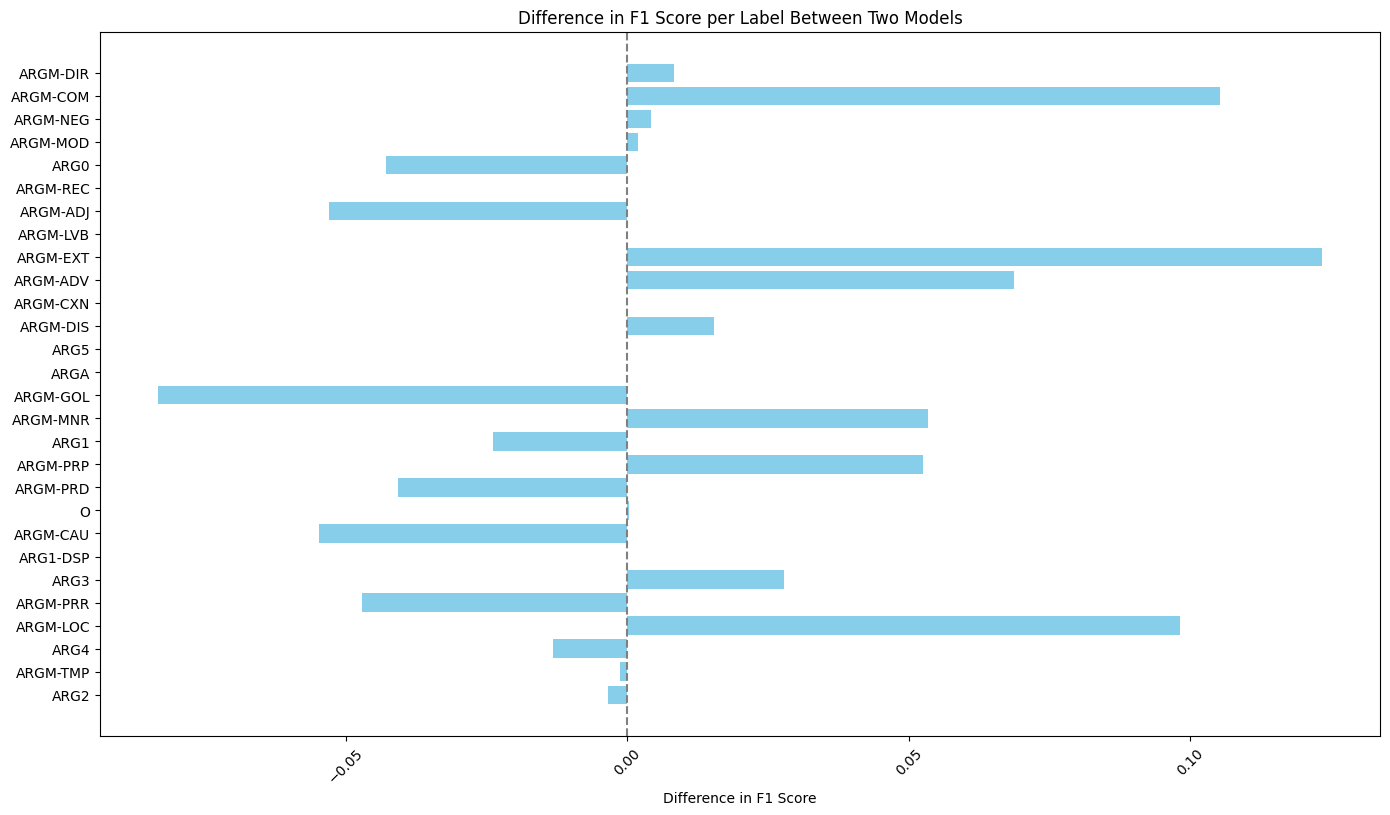

In [ ]:
# if path is given, it saves the image in such directory
plot_results(path= None)

A positive value indicates the advanced model outperformed the baseline, while a negative value suggests the opposite. The chart shows the advanced model outperformed the baseline in the classification of 11 labels, but it also fell behind on other 10, including the ARG0 label, which denotes the agent of the predicate. It is important to mention the presence of 7 labels for which no improvement was detected. Despite the advance model's awareness of the position of the predicate within the sentence, the baseline manages to recognize the agent more accurately. We would expect the proximity of the agent to the predicate in active sentences to help its identification.  As future research a behavioral testing specifically for the recognition of the agent would help to get a better understanding of such conduct. This proves how difficult it is in the NLP field to capture whether a model actually learns the human language, and that a more sophisticated model does not necessary leads to better performance. while the advanced model demonstrates marginal overall improvements, detailed analysis reveals that its relative performance increase on specific labels underscores the complex nature of progress in NLP model development

## Future Work:

Future work should focus on developing more precise and effective ways to mark predicates, especially in sentences with multiple predicates. One promising approach is to use special predicate-specific tokens like [PREDICATE1], [PREDICATE2], etc. to disambiguate arguments and learn predicate-specific argument representations. This can help capture the overall predicate-argument structure of the sentence and overcome limitations of baseline models.

Another potential direction is predicate indicator embeddings, where a special learned embedding indicates the predicate position. For each token, this predicate indicator embedding is concatenated to the token's word embedding if it is the predicate, else a null indicator embedding is used. This explicitly marks the predicate for the model, providing a clear signal for the SRL task.